In [1]:
# PERFORMANCE

import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import dgl
import matplotlib.pyplot as plt
sys.path.insert(0, "../lib")
from utils import set_device, collate
from laplacian import normalized_laplacian

# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = set_device(verbose=True)

%load_ext autoreload
%autoreload 2

cuda available


In [2]:
# Downloads the dataset if not found locally
from dataset import check_mnist_dataset_exists, datasampler, MNISTDataset, MNIST_rand
_ = check_mnist_dataset_exists()

train_data, train_labels, test_data, test_labels = datasampler(
    nb_selected_train_data=640, nb_selected_test_data=1024
)

In [3]:
from utils import load_model
from model import DGL_stock_Classifier
# Using the 4-neighbors trained model

net = DGL_stock_Classifier(
    1, 32, 50, 512, 10, 10
)

print(net)
if torch.cuda.is_available():
    net.to(device)

# LOAD MODEL



DGL_stock_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=32, bias=False)
        (1): Linear(in_features=1, out_features=32, bias=False)
        (2): Linear(in_features=1, out_features=32, bias=False)
        (3): Linear(in_features=1, out_features=32, bias=False)
        (4): Linear(in_features=1, out_features=32, bias=False)
        (5): Linear(in_features=1, out_features=32, bias=False)
        (6): Linear(in_features=1, out_features=32, bias=False)
        (7): Linear(in_features=1, out_features=32, bias=False)
        (8): Linear(in_features=1, out_features=32, bias=False)
        (9): Linear(in_features=1, out_features=32, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=32, out_features=50, bias=False)
        (1): Linear(in_features=32, out_features=50, bias=False)
        (2): Linear(in_features=32, out_features=50, bias=False)
        (3): Linear

In [4]:
#net.load_state_dict(load_model('Model_DGL_sto'))
net.load_state_dict(load_model('Cheb_DGL'))

<All keys matched successfully>

In [5]:
import sklearn
from sklearn.metrics import classification_report


def test_func(data_loader):
    net.eval()
    probs_Y = torch.Tensor()
    test_Y = torch.Tensor().int()
    for iter, (bg, label, signal) in enumerate(data_loader):
        probs_Y = torch.cat((probs_Y, torch.softmax(
            net(bg.to(device), signal.to(device)).to('cpu'), 1)), 0) #, lambda_max=(torch.ones(1024)*2).to(device)
        test_Y = torch.cat((test_Y, label.int()), 0)

    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)

    return sklearn.metrics.classification_report(test_Y, argmax_Y, digits=4, output_dict=True)

In [6]:
evalrange = range(0, 100, 5)

In [7]:
repz = []
for i in evalrange:
    report = []
    print(i, '%')
    for j in range(3):
        testset = MNIST_rand(test_data, test_labels,
                             removal_rate=i/100, rand=False)

        # Define a test function
        data_loader_test = DataLoader(testset, batch_size=1024,
                                      shuffle=False, collate_fn=collate)

        report.append(test_func(data_loader_test)['accuracy'])
    repz.append(report)

0 %


/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


5 %
10 %
15 %
20 %
25 %
30 %
35 %
40 %
45 %
50 %
55 %
60 %
65 %
70 %
75 %
80 %


/home/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


85 %
90 %
95 %


In [11]:
import pandas as pd
df = pd.DataFrame(repz)

df['mean'] = df.mean(1)
df['std'] = df.std(1)
print(df)
df.to_pickle('../resources/PlotStuff/edge_DGL')

           0         1         2      mean       std
0   0.974609  0.974609  0.974609  0.974609  0.000000
1   0.972656  0.973633  0.969727  0.972005  0.001660
2   0.969727  0.962891  0.963867  0.965495  0.003019
3   0.950195  0.958008  0.955078  0.954427  0.003222
4   0.939453  0.941406  0.940430  0.940430  0.000797
5   0.875977  0.900391  0.888672  0.888346  0.009970
6   0.789062  0.793945  0.795898  0.792969  0.002875
7   0.665039  0.658203  0.666016  0.663086  0.003476
8   0.560547  0.540039  0.541016  0.547201  0.009446
9   0.449219  0.435547  0.451172  0.445312  0.006951
10  0.368164  0.364258  0.362305  0.364909  0.002436
11  0.308594  0.280273  0.292969  0.293945  0.011582
12  0.291016  0.262695  0.261719  0.271810  0.013586
13  0.245117  0.243164  0.230469  0.239583  0.006494
14  0.210938  0.202148  0.203125  0.205404  0.003933
15  0.174805  0.179688  0.183594  0.179362  0.003595
16  0.159180  0.174805  0.183594  0.172526  0.010096
17  0.161133  0.181641  0.163086  0.168620  0.

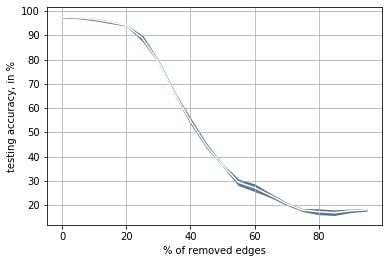

In [12]:
plt.plot(evalrange, df['mean']*100, color='white')
plt.fill_between(evalrange, df['mean']*100 - df['std']*100,
                 df['mean']*100 + df['std']*100, color="#3F5D7DD0")
#plt.title('Accuracy over number of removed edges')
plt.xlabel('% of removed edges')
plt.ylabel('testing accuracy, in %')
plt.grid()